# MNIST Classifier Model

## Goal
Now that we have created a model that can classify 3's and 7'2, lets create a model for the entire MNIST dataset with all the numbers 0-9.

In [82]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Getting data and viewing path

In [83]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [84]:
(path/"training/1").ls()

(#6742) [Path('/storage/data/mnist_png/training/1/42690.png'),Path('/storage/data/mnist_png/training/1/49817.png'),Path('/storage/data/mnist_png/training/1/12078.png'),Path('/storage/data/mnist_png/training/1/5862.png'),Path('/storage/data/mnist_png/training/1/36368.png'),Path('/storage/data/mnist_png/training/1/57223.png'),Path('/storage/data/mnist_png/training/1/37725.png'),Path('/storage/data/mnist_png/training/1/54103.png'),Path('/storage/data/mnist_png/training/1/29986.png'),Path('/storage/data/mnist_png/training/1/18207.png')...]

### This is what the data looks like

In [85]:
t = (path/"training/1").ls()
t_1 = Image.open(t[0])
t_1

<AxesSubplot:>

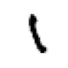

In [86]:
show_image(tensor(t_1))

## Loading data
To load our data, it may be beneficial to create a method to handle this process

In [87]:
#function used to load data appropriatly
def load_data(folder):
    dataList = []
    labelList = []
    for num in range(10):
        data_path = (path/folder/f'{num}').ls().sorted() #getting path
        
        stackedData = torch.stack([tensor(Image.open(o)) for o in data_path]) #Open each image and stack them
        stackedData = stackedData.float()/255.0 #squishing between 0-1
        
        dataList.append(stackedData) #adding to dataList
        labelList.extend([num]*len(data_path))#extending labelList
    
    #Convert so that each image data is in each row
    train_x = torch.cat(dataList).view(-1, 28*28) 
    train_y = tensor(labelList)
    
    return train_x, train_y

train_x, train_y = load_data("training")
test_x, test_y = load_data("testing")

### Creating dataloaders (Minibatches)

In [88]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(test_x,test_y))

dl_train = DataLoader(train_dset, batch_size=256)
dl_test = DataLoader(valid_dset, batch_size=256)

## Below is the functions we need to train and test the model
Most of these functions are copies and pasted from our previous MNIST model. The difference here is the loss function, which was swapped out for cross entropy (As we have multiple categories). And, our accuracy function has been adjusted due to switching out sigmoid for softmax (softmax ranges all values between 0-1).

In [31]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = F.cross_entropy(preds, yb) 
    loss.backward()

def train_epoch(model):
    for xb,yb in dl_train:
        calc_grad(xb, yb, model)
        
        for p in params: 
            p.data -= p.grad.data * lr
            p.grad.zero_()

def batch_accuracy(xb, yb):
    pred = xb.softmax(1)
    return batch_accuracy_helper(pred, yb)/float(yb.size(0))

def batch_accuracy_helper(preds, yb):
    return preds.argmax(dim=1).eq(yb).sum().float()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dl_test]
    return round(torch.stack(accs).mean().item(), 4)

def linear_layer(xb):
    return xb@w + b

def init_params(x, var=1.0): 
    return (torch.randn(x)*var).requires_grad_()

## Begin by initializing parameters

In [32]:
lr = 1.
w = init_params((28*28,10))
b = init_params(10)
params = w, b

w.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

## Now lets see if our loss improves for 1 epoch
It's good practice to try training the model manually to see if the loss improves. If it doesn't this means there may be some error.

In [33]:
validate_epoch(linear_layer)

0.1534

In [34]:
train_epoch(linear_layer)
validate_epoch(linear_layer)

0.1814

> Our loss improved, nice!

## Training

In [35]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
        
train_model(linear_layer, 20)

0.255 0.3079 0.3501 0.3783 0.4011 0.4184 0.4319 0.442 0.4507 0.4583 0.4647 0.4711 0.4758 0.4803 0.4833 0.4862 0.488 0.4887 0.4906 0.4925 

> 50% acc is not that bad, given there are 10 classes

## Using FastAI toolkit
As before, we can take everything we did above and condense it using FastAI's toolkit. Additionally, I will add non-linearity this time to see how much of a performance boost it gives.

In [93]:
dls = DataLoaders(dl_train, dl_test)

simple_net = nn.Sequential(
    nn.Linear(28*28,30), #30 neurons
    nn.ReLU(),
    nn.Linear(30, 10) # 30neurons into 10 output neurons (10 classes)
)

In [94]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=accuracy)

learn.fit(20, .01)

epoch,train_loss,valid_loss,accuracy,time
0,1.524066,2.803759,0.100900,00:01
1,0.953391,2.718991,0.102200,00:01
2,0.708434,2.372834,0.182800,00:01
3,0.585201,2.130398,0.294700,00:01
4,0.512490,1.966653,0.355500,00:01
5,0.463571,1.847218,0.389500,00:01
6,0.428147,1.752266,0.416000,00:01
7,0.401295,1.671586,0.435400,00:01
8,0.380187,1.600696,0.452600,00:01
9,0.363209,1.537549,0.467200,00:01


### So it seems that adding nonlinearity increased the accuracy by 10!

# Now lets try refining the learning rate

In [90]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=accuracy)

learn.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.428609,6.502268,0.100900,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.311028,4.431973,0.100900,00:01
1,1.791578,1.622997,0.327900,00:01


Minimum/10: 3.31e-01, steepest point: 3.31e-02


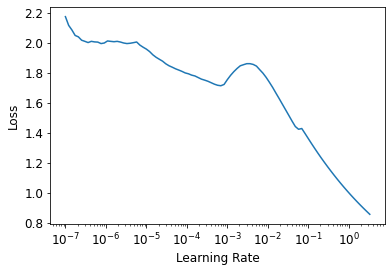

In [91]:
lr_min, lr_steep = learn.lr_find() #Finding best
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [92]:
learn.fine_tune(20, base_lr=3e-2) #Now lets train on the steepest

epoch,train_loss,valid_loss,accuracy,time
0,0.302600,3.178728,0.153700,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.833551,1.429206,0.407900,00:01
1,0.618095,1.583635,0.398200,00:01
2,0.459298,1.740223,0.393500,00:01
3,0.361341,1.833040,0.392500,00:01
4,0.308362,1.860949,0.398500,00:01
5,0.284963,1.830225,0.410000,00:01
6,0.278647,1.763200,0.424700,00:01
7,0.277990,1.687577,0.440100,00:01
8,0.282089,1.601443,0.458500,00:01
9,0.291083,1.502006,0.477600,00:01


## Adjusting the LR improved acc by 25!